### NLP Homework: 8

Sean Kennedy, SMU

In [89]:
import nltk
from nltk.tokenize import word_tokenize 
import numpy as np
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import itertools
import nltk
from nltk.tokenize import word_tokenize 
from nltk.chunk import *
from nltk.chunk.util import *
from nltk.chunk.regexp import *
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.display.max_colwidth=500
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [90]:
grammar = """
    NP:    {<DT><WP><VBP>*<RB>*<VBN><IN><NN>}
           {<NN|NNS|NNP|NNPS><IN>*<NN|NNS|NNP|NNPS>+}
           {<JJ>*<NN|NNS|NNP|NNPS><CC>*<NN|NNS|NNP|NNPS>+}
           {<JJ>*<NN|NNS|NNP|NNPS>+}
    """
def k_means(reviews, clusters=5, show_top=20):
    # build a TFIDFVectorizer with the engligh stop words
    vectorizer = TfidfVectorizer(stop_words='english')
    X = vectorizer.fit_transform(reviews)

    # execute KMeans on the vectorized data
    model = KMeans(n_clusters=clusters, init='k-means++', max_iter=100, n_init=1, random_state=5)
    model.fit(X)

    # print out the top terms per cluster for the user
    order_centroids = model.cluster_centers_.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names()
    all_clusters = {}
    for i in range(clusters):
        #print(f'cluster {i}'),
        text_terms = []
        for ind in order_centroids[i, :show_top]:
            text_terms.append(terms[ind])
            #print(f'{terms[ind]}')
        #print('\n')
        all_clusters.update({i:text_terms})
        
    return all_clusters
        
    

def extract_titles(movie_soup):
    title = movie_soup.find('meta', {'name': 'title'})
    return title['content']


def best_worst(reviews):
    worst = reviews.index(min(reviews))

    best = reviews.index(max(reviews))

    return worst, best


def extract_reviews(movie_soup):
    user_review_ratings = [
        tag.previous_element
        for tag in movie_soup.find_all('span', attrs={'class': 'point-scale'})
    ]

    worst, best = best_worst(list(map(int, user_review_ratings)))

    user_review_list = movie_soup.find_all('a', attrs={'class': 'title'})

    w_review_tag = user_review_list[worst]
    b_review_tag = user_review_list[best]

    w_review_link = 'https://www.imdb.com' + w_review_tag['href']
    b_review_link = 'https://www.imdb.com' + b_review_tag['href']

    return w_review_link, b_review_link


def extract_review_text(review_soup):
    tag = review_soup.find('div', attrs={'class': 'text show-more__control'})
    return tag.getText()


def sentence_tokenize(text):
    sentences = nltk.sent_tokenize(text)
    sentences = [nltk.word_tokenize(sent) for sent in sentences]
    sentences = [nltk.pos_tag(sent) for sent in sentences]
    sentences = [get_np_tags(sent) for sent in sentences]
    return sentences


def get_np_tags(sentence):
    nps = []

    cp = nltk.RegexpParser(grammar)
    tree = cp.parse(sentence)

    for subtree in tree.subtrees():
        if subtree.label() == 'NP':
            t = subtree
            t = ' '.join(word for word, tag in t.leaves())
            nps.append(t)

    return nps

def cluster_sentiment_scores(termsList):
    all_scores = []

    for terms in termsList:
        scores = []

        for term in terms:
            score = sid.polarity_scores(term)
            scores.append(score['compound'])

        all_scores.append(np.array(scores))

    summary = []
    for i, scores in enumerate(all_scores):
        summary.append({'cluster':i,
                           'mean':scores.mean(),
                           'median':np.median(scores),
                           'max':scores.max(),
                           'min':scores.min(),
                           'terms':termsList[i]})
            
            
    return all_scores, summary
def sentiment_scores(sentence): 
  
    analyzer = SentimentIntensityAnalyzer() 
  
    sentiment_dict = analyzer.polarity_scores(sentence) 
    return sentiment_dict['compound']


### Review Load (HW5)

In [91]:
url = '''https://www.imdb.com/search/title/?title_type=feature&user_rating=6.0,10.0
&num_votes=50000,&genres=thriller&view=simple&sort=user_rating,desc&count=250'''
response = requests.get(url, verify=False)
print(response)
soup = BeautifulSoup(response.text)

movie_titles = [
    tag.attrs['href'] for tag in soup.findAll('a', attrs={'class': None})
    if tag.attrs['href'].startswith('/title') & tag.attrs['href'].endswith('/')
]


movie_urls = [
    'https://www.imdb.com' + x + 'reviews' for x in set(movie_titles)
]

assert len(movie_urls) >= 100

movie_pages = [
    BeautifulSoup(requests.get(url, verify=False).text) for url in movie_urls 
]

titles = [extract_titles(x) for x in movie_pages]
#display(titles)

reviews = [extract_reviews(x) for x in movie_pages]
#display(reviews)

bad_reviews = [
    extract_review_text(BeautifulSoup(requests.get(url[0], verify=False).text)) for url in reviews 
]

good_reviews = [
    extract_review_text(BeautifulSoup(requests.get(url[1], verify=False).text)) for url in reviews 
]

c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


<Response [200]>


c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/adv

c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/adv

c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/adv

c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/adv

c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/adv

c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/adv

c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/adv

c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/adv

c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/adv

c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/adv

c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/adv

c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/adv

c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/adv

c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/adv

c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/adv

c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/adv

c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/adv

c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/adv

c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/adv

c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/adv

c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/adv

c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/adv

c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/adv

c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/adv

c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/adv

c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/adv

c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/adv

c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/adv

c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/adv

c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/adv

c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/adv

c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
c:\users\skennedy\appdata\local\programs\python\python37\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.imdb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/adv

In [92]:
#create a df of reviews/urls/titles
all_data = list(
    zip(titles, movie_titles, good_reviews, bad_reviews,
        [url[1] for url in reviews], [url[0] for url in reviews]))

all_data_df = pd.DataFrame(
    all_data,
    columns=['title', 'url', 'pos_review', 'neg_review', 'pos_url', 'neg_url'])

Perform a vocabulary-based sentiment analysis of the movie reviews you used in homework 5 and homework 7, by doing the following:

### 1.	In Python, load one of the sentiment vocabularies referenced in the textbook, and run the sentiment analyzer as explained in the corresponding reference. Add words to the sentiment vocabulary, if you think you need to, to better fit your particular text collection.



***The vader lexicon appears to be the industry standard for SE, so we'll use that lexicon to start and apply it to both our positive and negative review for each title.***

In [93]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = None
try:
    analyzer = SentimentIntensityAnalyzer('vader_lexicon')
except:
    nltk.download('vader_lexicon')
    analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\SKENNEDY\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [94]:
#Check a positive and negative review to see if working properly
analyzer.polarity_scores(all_data[1][2]), analyzer.polarity_scores(all_data[1][3])

({'neg': 0.122, 'neu': 0.756, 'pos': 0.122, 'compound': 0.2178},
 {'neg': 0.116, 'neu': 0.776, 'pos': 0.108, 'compound': -0.5894})

In [96]:
all_data_df['positive_review_sent'] = all_data_df.pos_review.apply(lambda x: sentiment_scores(x))
all_data_df['neg_review_sent'] = all_data_df.neg_review.apply(lambda x: sentiment_scores(x))

Text(0.5, 1.0, 'Postive Review Sentiment Scores')

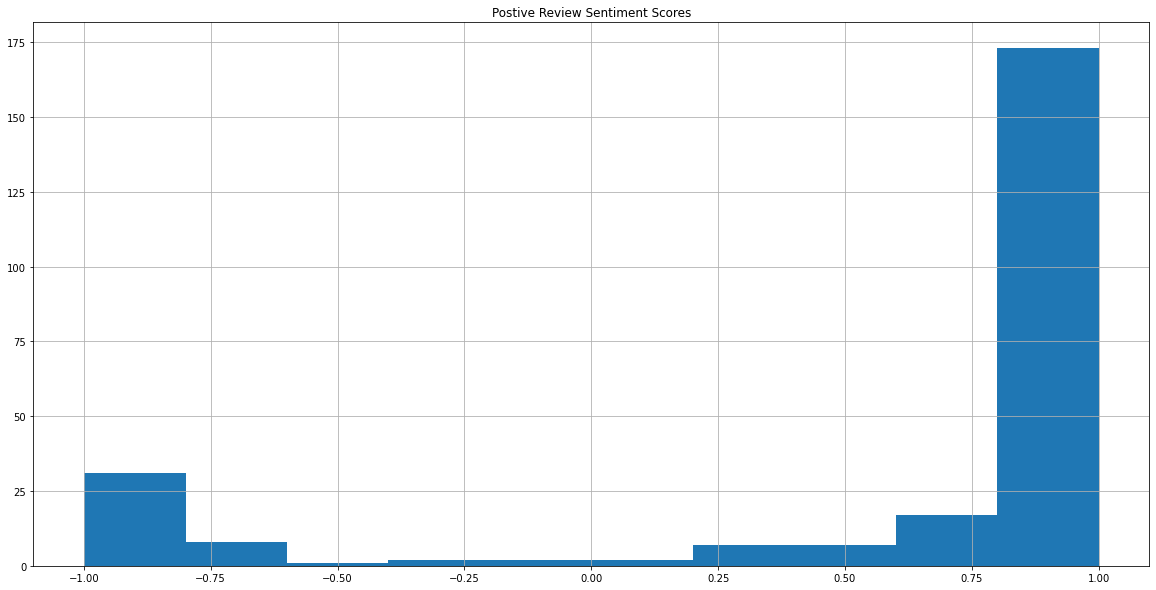

In [97]:
plt.figure(figsize=(20, 10))
all_data_df.positive_review_sent.hist()
plt.title('Postive Review Sentiment Scores')

Text(0.5, 1.0, 'Negative Review Sentiment Scores')

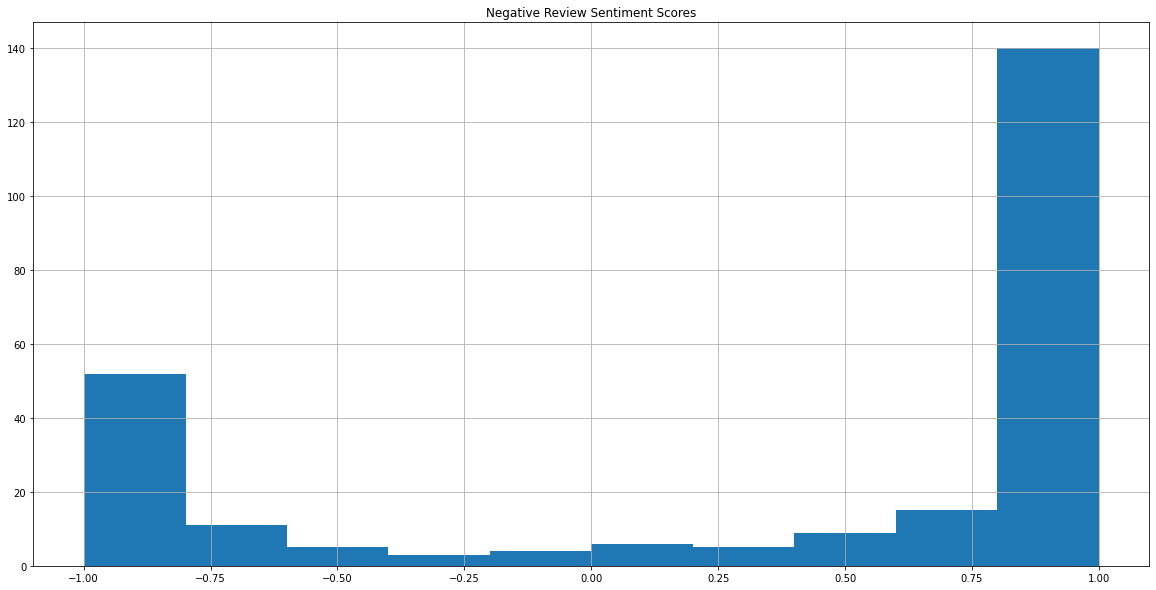

In [98]:
plt.figure(figsize=(20, 10))
all_data_df.neg_review_sent.hist()
plt.title('Negative Review Sentiment Scores')

***From the looks of our two distributions above, we can see that overall our positive are skewed towards positive sentiment scores. Unfortunately, so do our negative reviews. This couuld be due to a variety of factors - not the least of which is the absence of context provided to the model. Our algorithm is totally unaware of the fact that the text in question is a collection of movie reviews. Thankfully, the negative reviews exhibit lower sentiment scores as a group relative to their positive counterparts - but the high number of positive reviews is disturbing.***

#### 2.	For each of the clusters you created in homework 7, compute the average, median, high, and low sentiment scores for each cluster. Explain whether you think this reveals anything interesting about the clusters.

***Recreating our clusters from HW 5***

In [102]:
all_reviews = good_reviews
all_reviews.extend(bad_reviews)
cluster_5 = k_means(all_reviews)

In [103]:
# get the cluster sentiment scores for the 5 clusters
scores, summary = cluster_sentiment_scores(list(cluster_5.values()))
pd.DataFrame(summary)

,cluster,mean,median,max,min,terms
0,0,0.103170,0.0,0.6369,0.0000,"[movie, film, action, just, story, like, movies, good, time, real, great, watch, best, seen, don, characters, ve, people, plot, really]"
1,1,0.119080,0.0,0.6369,0.0000,"[film, did, movie, story, just, like, time, people, didn, really, police, films, great, plot, don, good, sure, best, make, bit]"
2,2,0.062720,0.0,0.6369,-0.6908,"[hitchcock, film, stewart, time, grant, best, movie, character, brilliant, james, murder, performance, bond, films, alfred, hepburn, lecter, does, just, like]"
3,3,0.071325,0.0,0.6249,-0.1027,"[movie, film, book, read, good, really, blah, like, don, story, makes, edward, know, great, mystery, time, looking, doesn, thriller, susan]"
4,4,0.049645,0.0,0.6369,-0.6597,"[film, great, story, pitt, time, films, barton, brad, sean, niro, evil, cast, best, like, character, lousy, excellent, man, jones, kevin]"


***From the 5 cluster groupings, we can see that all of them have a skew towards positive reviews. Not entirely unexpected given that the reviews as a whole are skewed positively. Of the 5 clusters, only clusters 2, 3 and 4 exhibit any words that would be classified as negative. Cluster 1 was the most positive with words like great, good and best contributing to the large positive sentiment score.***

In [101]:
# get the cluster sentiment for the 20 clusters
cluster_10 = k_means(all_reviews, clusters=10)
scores, summary = cluster_sentiment_scores(list(cluster_10.values()))
pd.DataFrame(summary)

,cluster,mean,median,max,min,terms
0,0,0.063020,0.0,0.4588,0.0000,"[movie, movies, film, time, good, just, list, imdb, seen, like, com, read, story, 10, action, http, people, favorite, www, character]"
1,1,0.123265,0.0,0.6369,0.0000,"[film, action, bourne, films, movie, great, characters, story, good, man, does, character, like, time, best, just, interesting, director, plot, john]"
2,2,0.103170,0.0,0.6369,0.0000,"[movie, film, just, like, don, great, good, characters, best, action, make, movies, really, people, world, think, did, story, time, watch]"
3,3,0.137815,0.0,0.6369,0.0000,"[film, truly, excellent, time, best, movie, life, story, man, really, just, fiction, gattaca, good, watch, seen, young, okay, better, role]"
4,4,-0.017040,0.0,0.1531,-0.4939,"[gere, edward, susan, norton, fear, linney, primal, richard, film, solid, hackman, par, welles, laura, nominated, star, seven, mcdormand, gale, chicago]"
5,5,-0.008260,0.0,0.4404,-0.6486,"[lucas, drug, boring, real, frank, serial, really, movie, protected, like, film, washington, bruno, just, rats, talk, people, look, taj, killer]"
6,6,0.087905,0.0,0.6369,-0.5994,"[bond, film, action, movie, love, james, craig, mcclane, casino, best, die, scene, goldfinger, great, emad, hollywood, favorite, 10, gibson, max]"
7,7,0.071325,0.0,0.6249,0.0000,"[movie, film, story, like, time, good, don, ve, just, way, did, great, book, seen, little, plot, really, movies, think, action]"
8,8,0.038155,0.0,0.4019,0.0000,"[hitchcock, grant, cary, hepburn, movie, film, alfred, classic, northwest, romantic, films, north, hannay, jimmy, movies, mason, favourite, stewart, charade, bergman]"
9,9,-0.050795,0.0,0.6369,-0.6908,"[film, horror, like, movie, time, story, films, just, people, dead, character, best, murder, real, blah, way, blood, human, halloween, movies]"


***From the 10 cluster groupings, we can see that almost all of them have a skew towards positive reviews with only a few groupings (4/5/9) having negative average sentiment. Words like boring and ruined are contributing to this negative polarity. Grouping 1 had the highest positive sentiment due to words like best, great and interesting. Ideally, we would like to run this analysis without any proper names to those are not likely to contribute to the overall sentiment of the text (they are more likely the subject of any sentiment expressed in the review). Interestingly, there were 6 clusters that had no words scored with negative sentiment, again this points to our review base needing some clean up since we expect more negative sentiment to appear in our reviews (they were 50/50 at the outset).***